## Earthquake time prediction using XGB

This kernel manipulates with a dataset that was generated using the kernel https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples

* [Additional methods](#addmethods)
* [Datasets loading and preparation](#data)
* [Feature selection](#feature_selection)
* [Cross-validation strategy](#CV)
* [Validation and Learning Curves](#curves)
* [Parameters tuning](#tuning)
    * [Exhaustive tuning with RandomizedSearchCV](#rand)
    * [Fine tuning with GridSearcCV](#grid)
* [Make a prediction using the chosen CV strategy and tuned algorithm](#preds)    

22.06.2019
    

In [1]:
import multiprocessing
n_jobs = multiprocessing.cpu_count()-1

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as RandomizedPCA

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedShuffleSplit

from time import time, ctime

import xgboost

**Additional methods** <a class="anchor" id="addmethods"></a>

In [2]:
def changeparam(value, param):
    if param == 'max_depth' or param == 'min_child_weight':
        if value >= 1 and value <= 10:
            return list(filter(lambda x: x != 0, [ value + i for i in [-1, 0, 1]]))
        else: 
            return value
    elif param == 'n_estimators':
        if value >= 1 and value < 10:
            return list(filter(lambda x: x != 0, [ value + i for i in [-1, 0, 1]]))
        elif value >= 10 and value < 100:
            return [ value + i for i in [-5, 0, 5]]
        elif value >= 100 and value < 1000:
            return [ value + i for i in [-20, -10, 0, 20, 10]]
        elif value >= 1000 and value < 10000:
            return [ value + i for i in [-200, -100, 0, 100, 200]]
        elif value >= 10000:
            return [ value + i for i in [-2000, -1000, 0, 1000, 2000]]

def plotCurves(model, X, Y, param_range, param_name, scoring):
    best_values = []
 
    for i, st_i in enumerate(scoring):
            fig, ax = plt.subplots( nrows = 1, ncols = 2, figsize=(18, 5))

            train_scores, test_scores = validation_curve(
                model, X, Y.values.ravel(), param_name=param_name, param_range=param_range,
                cv=cv, scoring=scoring[i], n_jobs = n_jobs, error_score=0)

            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)

            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            ax[0].plot(param_range, train_scores_mean, label="Training score", color="darkorange")
            ax[0].fill_between(param_range, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.2,
                         color="darkorange")

            ax[0].plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
            ax[0].fill_between(param_range, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.2,
                         color="navy")
            ax[0].legend(loc="best")

            ax[0].set_title('Validation Curve for '+scoring[i])
            ax[0].set_ylabel(scoring[i])
            ax[0].set_xlabel(param_name)

            ax[0].set_ylim(test_scores_mean[-1] - abs(6*test_scores_std[-1]), 
                           test_scores_mean[-1] + abs(6*test_scores_std[-1]))
            ax[0].grid(True)

            best_param = list(param_range)[np.argmax(test_scores_mean)]
            
            if param_name == 'n_estimators':
                model.n_estimators = best_param
            elif param_name == 'max_depth':
                model.max_depth = best_param
            elif param_name == 'min_child_weight':
                model.min_child_weight = best_param

            best_values.append(best_param)

            sizes = np.linspace(.1, 1.0, 10)
            train_sizes, train_scores, test_scores = learning_curve(model, 
                                                                    X, Y.values.ravel(), 
                                                                    cv = cv, 
                                                                    scoring=scoring[i],
                                                                    n_jobs = n_jobs, 
                                                                    train_sizes = sizes,
                                                                    error_score=0)
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            ax[1].fill_between(sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
            ax[1].fill_between(sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
            ax[1].plot(sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
            ax[1].plot(sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")

            ax[1].set_title('Learning curve for '+scoring[i] +' for ' + param_name + ' = '+ str(best_param) )
            ax[1].set_ylabel(scoring[i])
            ax[1].set_xlabel('Number training observations')
            ax[1].grid(True)
            ax[1].legend(loc="best")

            plt.pause(0.01)
    fig.tight_layout()
    return best_values

def plotfig (ypred, yactual, strtitle):
    plt.scatter(ypred, yactual.values.ravel())
    plt.title(strtitle)
    plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.show()

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def mode_custom(List): 
    dict = {} 
    count, itm = 0, '' 
    for item in reversed(List): 
        dict[item] = dict.get(item, 0) + 1
        if dict[item] >= count : 
            count, itm = dict[item], item 
    return(itm) 

**Datasets loading and preparation** <a class="anchor" id="data"></a>

In [3]:
XY = pd.read_csv('LANL_train.csv')
X_TEST = pd.read_csv('LANL_test.csv')
col = [c for c in XY.columns if c not in ['time_to_failure']]
X = XY[col]
Y = XY['time_to_failure']
print(X.shape, X_TEST.shape, Y.shape)

(4194, 138) (2624, 138) (4194,)


In [4]:
print(X.isnull().values.any())
print(X_TEST.isnull().values.any())

False
False


In [5]:
# Check the number of features with one unique value 
allunique = X.nunique().reset_index()
lst = [allunique.loc[i,'index'] for i in range(len(allunique)) if allunique.loc[i,0] == 1]
print(len(lst), lst)

2 ['abs_min', 'abs_q01']


In [6]:
# Drop colums with one unique value (in this case this is null)
X.drop(lst, axis = 1, inplace = True)
X_TEST.drop(lst, axis = 1, inplace = True)
print(X.shape, X_TEST.shape)

(4194, 136) (2624, 136)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
scaler = StandardScaler()

scaler.fit(X)
X = scaler.transform(X)

scaler.fit(X_TEST)
X_TEST = scaler.transform(X_TEST)

**Feature selection** <a class="anchor" id="feature_selection"></a>

**Bi-objective feature selection**

The features were selected using a metaheuristic optimization approach which idea had been presented in https://iopscience.iop.org/article/10.1088/1742-6596/1210/1/012086/meta. We were considering two objectives: maximization of R-squared and features number minimization. In order to check the idea an get a solution faster, we performed the experiment for Linear Regression model. So, we got 79 features that allow getting almost the same private score, but with less time consumption. 

For demonstration purpose, in the figure below you can see the results of the first phase of the optimization procedure that allows concluding the best R-squared is about 0.52 with approximately 80 features.  

<img src="phase1.png" width="500" class="image left" />

 


In [8]:
# sel_fea = pd.read_csv('features.csv', sep = ';', header = 0)
# features = list(sel_fea.loc[0,:])
# X = X.iloc[:,features]
# X_TEST = X_TEST.iloc[:,features]
# print(X.shape, X_TEST.shape, Y.shape)

# X = scaler.transform(X)
# X_TEST = scaler.transform(X_TEST)

**PCA**

This approach of feature selection worsen the score. 

In [9]:
# pca = RandomizedPCA(copy = True, 
#                     iterated_power = 3,
#                     n_components = 55, 
#                     svd_solver='randomized', 
#                     random_state = 0, 
#                     whiten=False).fit(X)

# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.grid()

# X = pca.transform(X)
# print('Dimension of train dataset', X.shape)

# X_TEST = pca.transform(X_TEST)
# print('Dimension of test dataset', X_TEST.shape)

**Cross-validation strategy** <a class="anchor" id="CV"></a>

In [10]:
n_fold = 5

cv = ShuffleSplit(n_splits=n_fold, test_size=0.4, random_state = 0)
# cv = KFold(n_splits=n_fold, shuffle=True, random_state = 0)

**XGBoost initialization**

In [11]:
# scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
#            'neg_mean_squared_log_error','neg_median_absolute_error',
#            'explained_variance']

scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
           'neg_median_absolute_error', 'explained_variance']

n_estimators_range = range(10, 5000, 500) 
max_depth_range = np.arange(1, 11, 2)
min_child_weight_range = np.arange(1, 11, 2)

model = xgboost.XGBRegressor(learning_rate = 0.01, 
                            criterion = 'mae',
                            subsample = 1,
                            colsample_bytree = 1,
                            max_depth = 1,
                            min_child_weight = 1
                            )

model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='mae', gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Validation and Learning Curves <a class="anchor" id="curves"></a>

1. On **n_estimators** parameter

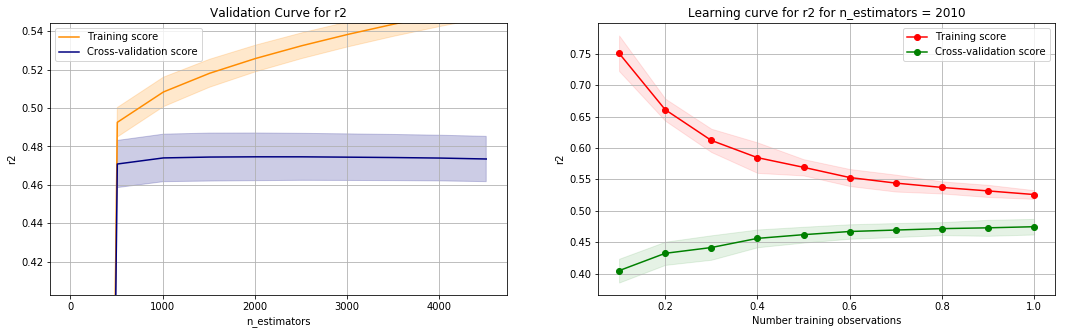

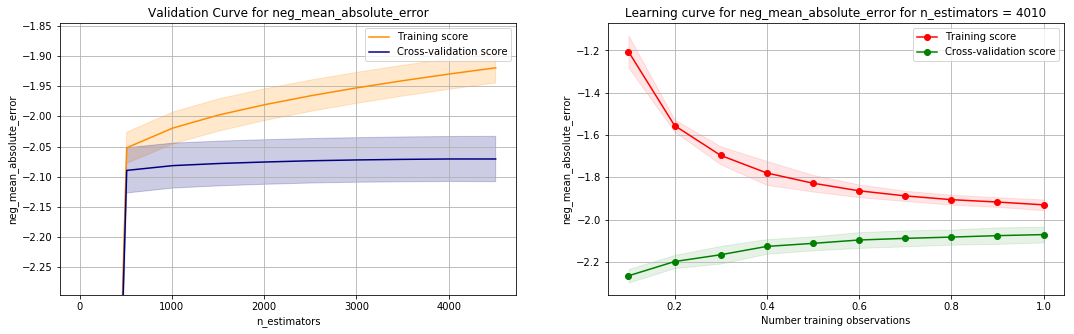

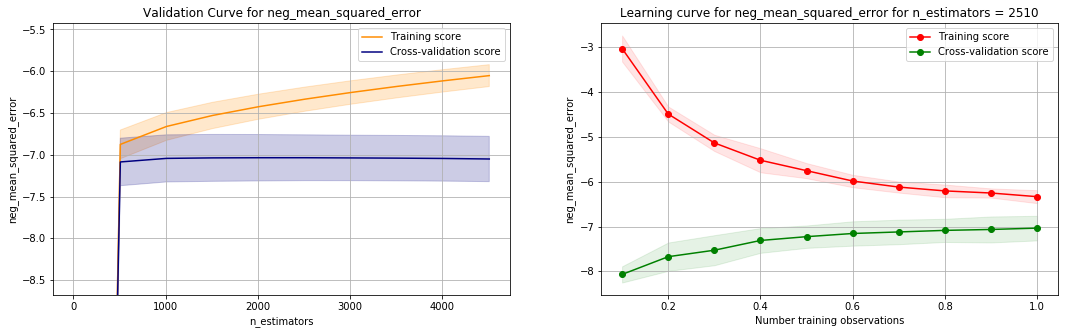

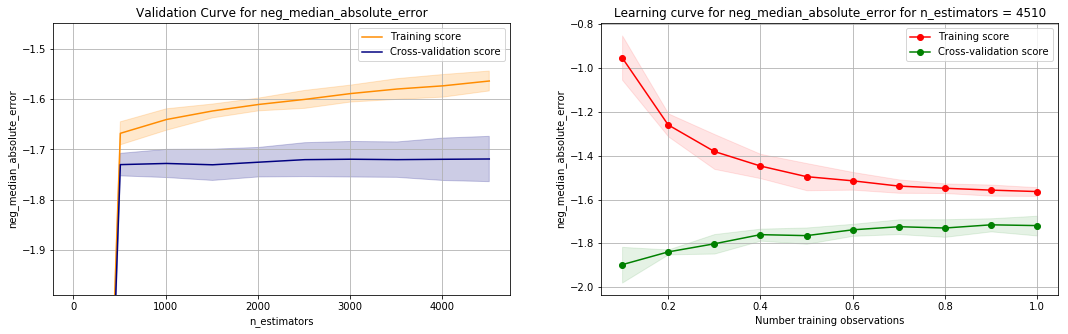

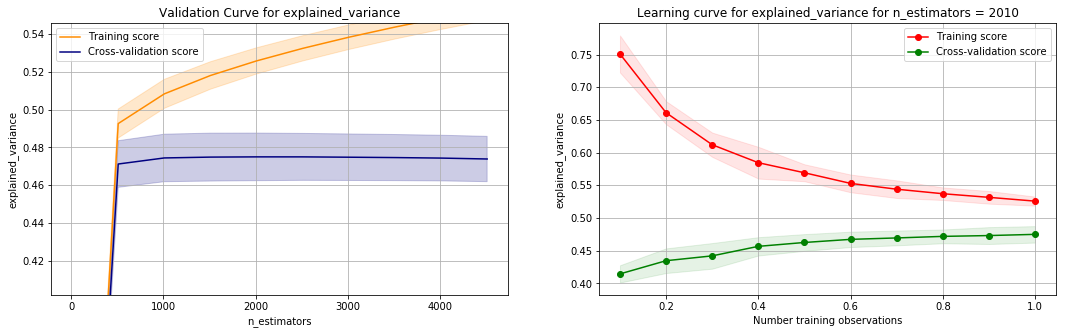

In [12]:
best_n_estimators = plotCurves(model, X, Y, n_estimators_range, 'n_estimators', scoring)

In [13]:
model.n_estimators = mode_custom(best_n_estimators)
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='mae', gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=2010,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

2. On **max_depth** parameter

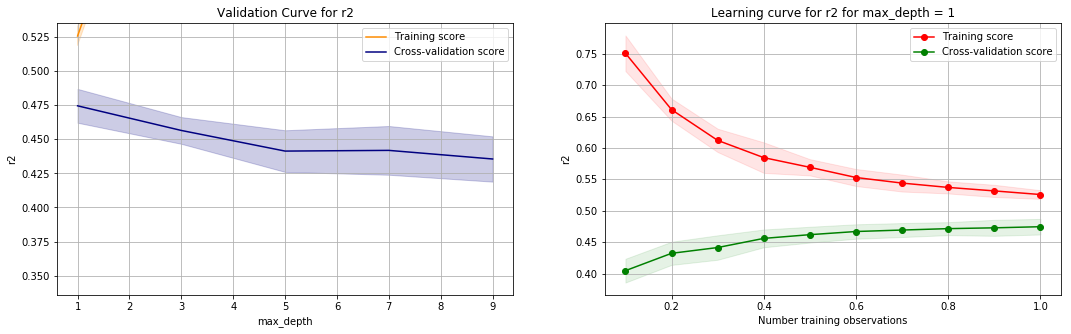

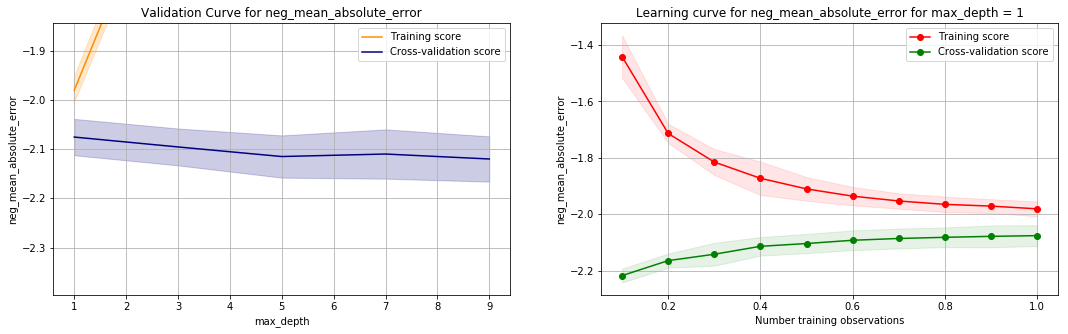

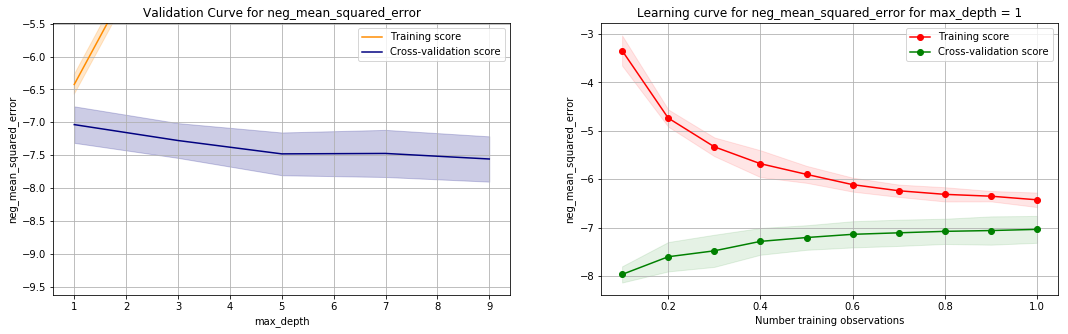

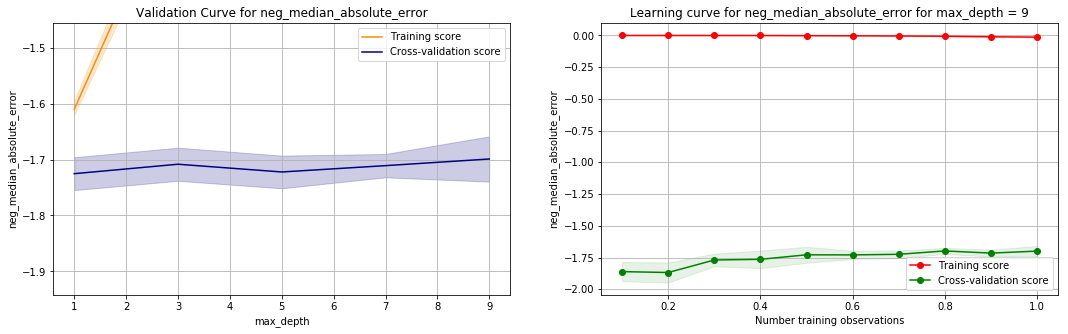

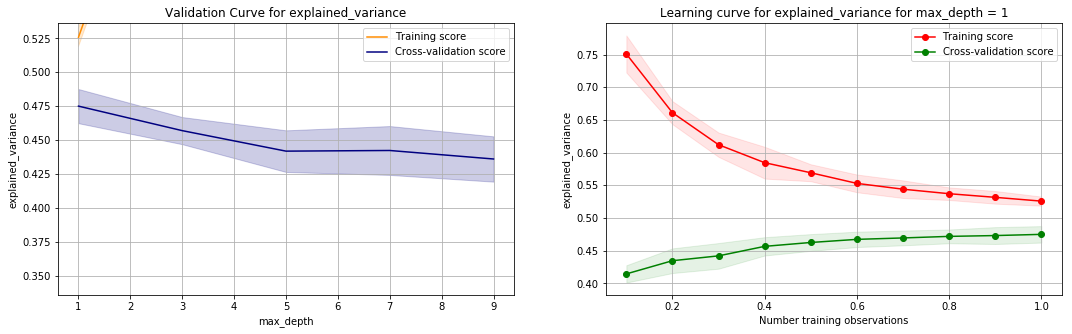

In [14]:
best_max_depth = plotCurves(model, X, Y, max_depth_range, 'max_depth', scoring)

In [15]:
model.max_depth = mode_custom(best_max_depth)
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, criterion='mae', gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=2010,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

3. On **min_child_weight** parameter

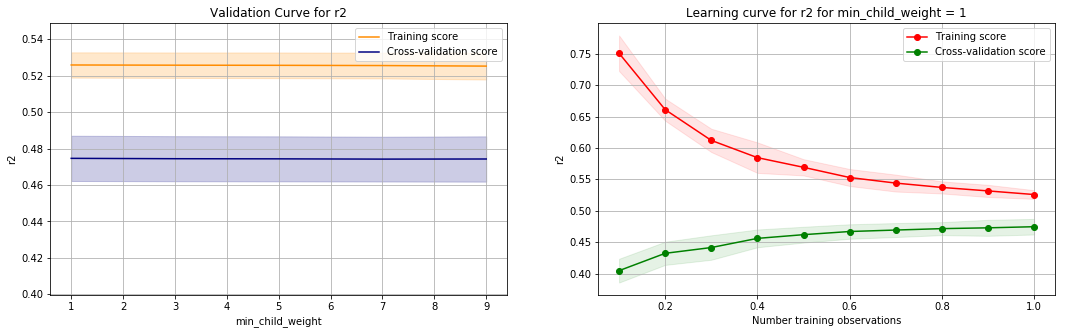

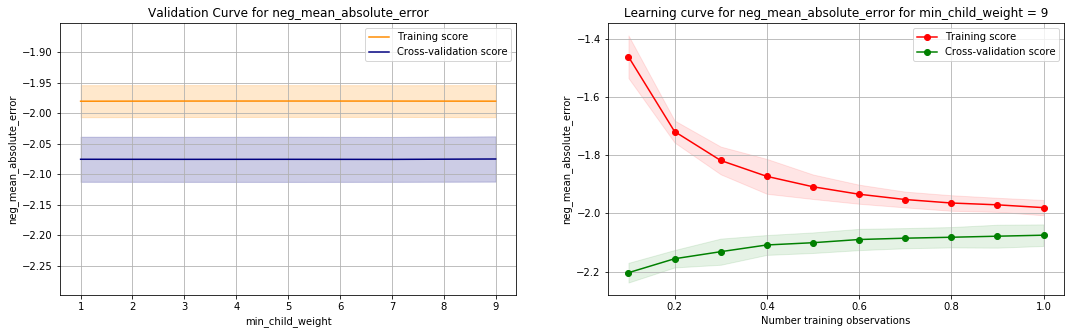

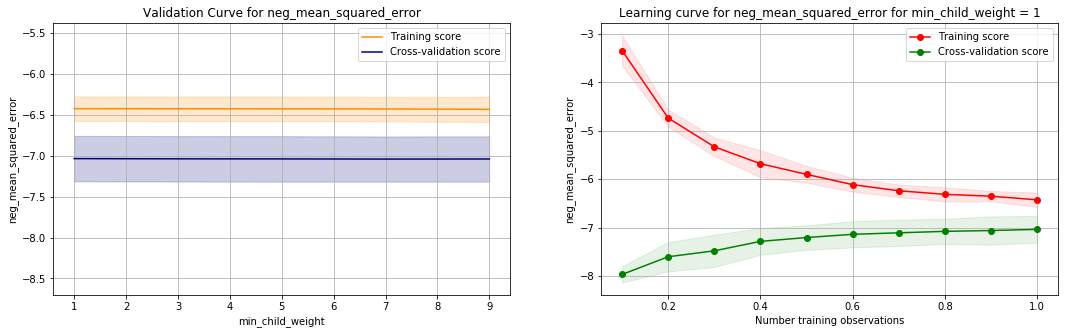

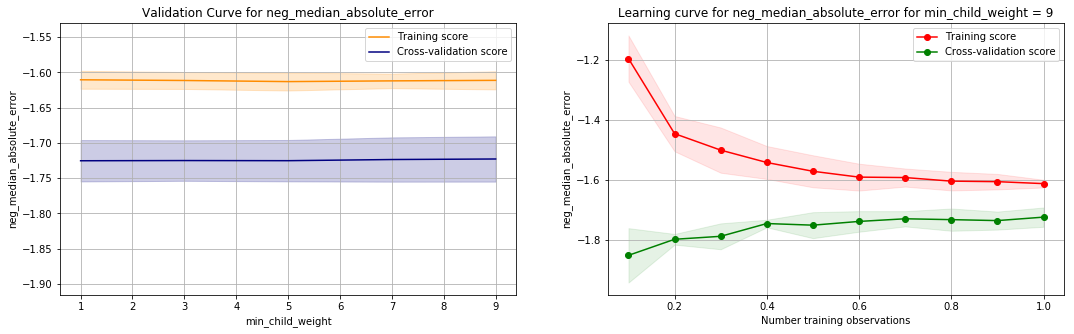

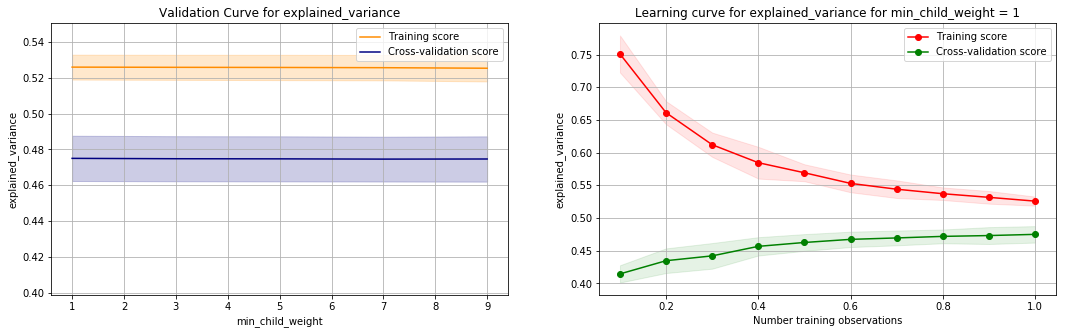

In [16]:
best_min_child_weight = plotCurves(model, X, Y, min_child_weight_range, 'min_child_weight', scoring)

In [17]:
model.min_child_weight = mode_custom(best_min_child_weight)
ch_algorithm = model

### Parameters tuning <a class="anchor" id="tuning"></a>

**Exhaustive tuning with RandomizedSearchCV** <a class="anchor" id="rand"></a>

In [18]:
# random_grid = {'n_estimators': n_estimators_range,
#                'learning_rate': [0.01],
#                'max_depth': max_depth_range,
#                'min_child_weight': min_child_weight_range,
#                'subsample' : [1],
#                'colsample_bytree' : [1],
#                'criterion' : ['mae'],
#               }

# model = xgboost.XGBRegressor()

# n_iter_search = 20
# random_search = RandomizedSearchCV(estimator = model, 
#                                     param_distributions = random_grid, 
#                                     n_iter = n_iter_search, 
#                                     cv = cv, 
#                                     scoring = 'neg_mean_absolute_error',
#                                     verbose = 10, 
#                                     error_score = 0,
#                                     random_state = 42,
#                                     n_jobs = n_jobs)

# start = time()
# random_search.fit(X, Y)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time() - start), n_iter_search))
# report(random_search.cv_results_)

# ch_algorithm = random_search.best_estimator_

**Fine tuning with GridSearcCV** <a class="anchor" id="grid"></a>

In [19]:
%%time

search_grid = {'n_estimators': changeparam(ch_algorithm.n_estimators, 'n_estimators'),
               'learning_rate': [0.01],
               'max_depth': changeparam(ch_algorithm.max_depth, 'max_depth'),
               'min_child_weight': changeparam(ch_algorithm.min_child_weight, 'min_child_weight'),
               'subsample' : [0.5, 1],
               'colsample_bytree' : [0.5, 1],
               'criterion' : ['mae'],
              }

n_iter_search = sum([len(value) for key, value in search_grid.items()])
model = xgboost.XGBRegressor()

grid = GridSearchCV(model, 
                    search_grid, 
                    cv=cv, 
                    scoring = 'neg_mean_absolute_error', 
                    verbose = 10,
                    error_score = 0,
                    n_jobs = n_jobs)

start = time()
grid.fit(X, Y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

report(grid.cv_results_)

ch_algorithm = grid.best_estimator_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=31)]: Using backend LokyBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done  10 tasks      | elapsed:   26.2s
[Parallel(n_jobs=31)]: Done  23 tasks      | elapsed:   29.5s
[Parallel(n_jobs=31)]: Done  36 tasks      | elapsed:   52.3s
[Parallel(n_jobs=31)]: Done  51 tasks      | elapsed:   57.1s
[Parallel(n_jobs=31)]: Done  66 tasks      | elapsed:  1.3min
[Parallel(n_jobs=31)]: Done  83 tasks      | elapsed:  1.5min
[Parallel(n_jobs=31)]: Done 100 tasks      | elapsed:  1.9min
[Parallel(n_jobs=31)]: Done 119 tasks      | elapsed:  2.3min
[Parallel(n_jobs=31)]: Done 138 tasks      | elapsed:  2.8min
[Parallel(n_jobs=31)]: Done 159 tasks      | elapsed:  3.1min
[Parallel(n_jobs=31)]: Done 180 tasks      | elapsed:  3.8min
[Parallel(n_jobs=31)]: Done 203 tasks      | elapsed:  4.3min
[Parallel(n_jobs=31)]: Done 226 tasks      | elapsed:  4.7min
[Parallel(n_jobs=31)]: Done 251 tasks      | elapsed:  5.3min
[Parallel(n_jobs=31)]: Done 276 tasks      | elapsed:  

RandomizedSearchCV took 656.32 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: -2.070 (std: 0.039)
Parameters: {'colsample_bytree': 0.5, 'criterion': 'mae', 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 1810, 'subsample': 0.5}

Model with rank: 2
Mean validation score: -2.070 (std: 0.039)
Parameters: {'colsample_bytree': 0.5, 'criterion': 'mae', 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 1810, 'subsample': 0.5}

Model with rank: 3
Mean validation score: -2.071 (std: 0.039)
Parameters: {'colsample_bytree': 0.5, 'criterion': 'mae', 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 1910, 'subsample': 0.5}

CPU times: user 36 s, sys: 160 ms, total: 36.2 s
Wall time: 10min 56s


In [20]:
ch_algorithm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, criterion='mae', gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=1810,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

In [21]:
ch_algorithm.n_estimators =ch_algorithm.n_estimators*2
# ch_algorithm.learning_rate = ch_algorithm.learning_rate / 2
ch_algorithm.n_jobs = n_jobs

In [22]:
ch_algorithm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, criterion='mae', gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=3620,
       n_jobs=31, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

### Make a prediction using the chosen CV strategy and tuned algorithm <a class="anchor" id="preds"></a>


Fold 0 started at Wed Jul  3 09:24:11 2019
MAE:  2.093953910176348
R2:  0.46583144810804933

Fold 1 started at Wed Jul  3 09:32:50 2019
MAE:  2.083823188512749
R2:  0.4595445953013826

Fold 2 started at Wed Jul  3 09:41:24 2019
MAE:  2.058070735688986
R2:  0.45462484000689163

Fold 3 started at Wed Jul  3 09:49:23 2019
MAE:  2.0472121030554016
R2:  0.4775685923495979

Fold 4 started at Wed Jul  3 09:57:21 2019
MAE:  2.1529218583699112
R2:  0.44627132235353073
CV mean MAE: 2.0872, std: 0.0369.
CV mean R2:  0.4608, std: 0.0106.


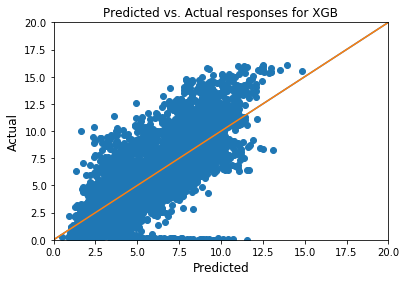

CPU times: user 7h 13min 38s, sys: 3min 56s, total: 7h 17min 35s
Wall time: 41min 10s


In [23]:
%%time

submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
oof = np.zeros(len(X))
prediction = np.zeros(len(submission))
mae, r2 = [], []

for fold_n, (train_index, valid_index) in enumerate(cv.split(X)):
    print('\nFold', fold_n, 'started at', ctime())

    X_train = X[train_index]
    X_valid = X[valid_index]
    Y_train = Y.values.ravel()[train_index]
    Y_valid = Y.values.ravel()[valid_index]
       
    best_model = ch_algorithm.fit(X_train, Y_train)
    y_pred = best_model.predict(X_valid)   
  
    oof[valid_index] = y_pred

    mae.append(mean_absolute_error(Y_valid, y_pred))
    r2.append(r2_score(Y_valid, y_pred))

    print('MAE: ', mean_absolute_error(Y_valid, y_pred))
    print('R2: ', r2_score(Y_valid, y_pred))

    prediction += best_model.predict(X_TEST)
        
prediction /= n_fold

print('='*45)
print('CV mean MAE: {0:.4f}, std: {1:.4f}.'.format(np.mean(mae), np.std(mae)))
print('CV mean R2:  {0:.4f}, std: {1:.4f}.'.format(np.mean(r2), np.std(r2)))

plotfig(best_model.predict(X), Y, 'Predicted vs. Actual responses for XGB')

# non_zeros_ind = np.argwhere(oof != 0)[:, 0]
# oof     = oof[non_zeros_ind]
# Y_fixed = pd.DataFrame(Y.values[non_zeros_ind])
# plotfig(oof, Y_fixed, 'Predicted vs. Actual responses for XGB')
# print('\nMAE: ', mean_absolute_error(Y_fixed, oof))

In [24]:
# scores = cross_validate(best_model, X, Y, cv=cv, scoring = {'neg_mean_absolute_error', 'r2'})

# print('CV mean MAE: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores['test_neg_mean_absolute_error']), 
#                                                    np.std(scores['test_neg_mean_absolute_error'])))
# print('CV mean R2:  {0:.4f}, std: {1:.4f}.'.format(np.mean(scores['test_r2']), 
#                                                    np.std(scores['test_r2'])))

In [25]:
submission['time_to_failure'] = prediction 
print(submission.head())
submission.to_csv('submission.csv')

            time_to_failure
seg_id                     
seg_00030f         3.497399
seg_0012b5         5.822462
seg_00184e         6.110243
seg_003339         8.717580
seg_0042cc         7.091057
